In [ ]:
 У нас имеется база данных в кикхаусе, куда ежедневно записываются данные по пользователям ленты новостей.
Лента новостей представляет из себя посты с возможностью их просматривать, лайкать, и также отправлять сообщения
друг другу. Действия по ленте новостей это like и view, действия по месссенджеру заполняются отдельной схемой в БД
и включают просто сообщения, кому и когда. В целом, лента и мессенджер составляют некое приложение, которое мы 
хотим развивать, наполняя новыми пользователями и поддерживая их активность.

In [ ]:
'''К нам пришли наши коллеги из ML-отдела и рассказали, что планируют выкатывать новый алгоритм, рекомендующий
нашим пользователям интересные посты.

1.Алгоритм добавляет пользователям 1-2 просмотра
2.Вероятность того, что он сработает, составляет 90%
3.Если у пользователя меньше 50 просмотров, то алгоритм не сработает

Вы предполагаете, что увеличение числа просмотров приведёт и к увеличению лайков на пользователя.
Встаёт вопрос: сможем ли мы обнаружить различия в среднем количестве лайков на пользователя?
Чтобы ответить на этот вопрос,проведём симуляцию Монте-Карло.


Распределения, из которых мы будем симулировать просмотры и пользовательские CTR, мы построим 
на основе периода АА-теста '2024-12-27' по '2025-01-02'. 

На эксперимент нам выделили неделю. Допустим, что за эту неделю в наш сервис зайдёт столько же 
пользователей, сколько зашло в период АА-теста  '2024-12-27' по '2025-01-02'. 
Мы планируем разбивать пользователей на две группы в соотношении 50/50.
Посчитайте, сколько пользователей в таком случае придётся на одну группу.

Эффект алгоритма на просмотры сымитируем следующим образом:
group_B_views + ((1 + np.binomial(n=1, p=0.5, size=размер_выборки)) * 
                 np.binomial(n=1, p=0.9, size=размер_выборки) * (group_B_views >= 50)). '''

In [1]:
# Импортируем все необходимое
from scipy import stats
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, ttest_ind
from tqdm import tqdm
# Это создает объект-генератор случайных чисел (RNG) из NumPy
rng = np.random.default_rng() 

In [2]:
#  Соединяемся с кликхаус
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20250120',
              'user':'student',
              'password':'dpo_python_2020'}
# Запрос в кликхаус для распределения просмотров
q = """
SELECT views, count() as users
FROM(SELECT
    user_id,
    sum(action = 'view') as views
    FROM {db}.feed_actions 
    WHERE toDate(time) >= toDate('2024-12-27') and toDate(time) <= toDate('2025-01-02')
    GROUP BY user_id)
group by views
order by views
"""
# Запрос исходной таблицы из БД для понимания структуры таблицы
q_table = """
SELECT *
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) <= toDate('2025-01-04')"""

In [3]:
# Наша исходная таблица со всеми данными по каждому пользователю и группой exp_group
df_table = ph.read_clickhouse(q_table, connection=connection)
df_table.head(5)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,123767,2040,view,2025-01-04 20:06:53,1,21,Russia,Samara,Android,organic,1
1,129655,2116,view,2025-01-04 20:06:53,0,26,Russia,Saint Petersburg,iOS,organic,4
2,131026,2095,view,2025-01-04 20:06:53,1,22,Russia,Moscow,Android,organic,4
3,28786,2167,view,2025-01-04 20:06:54,1,16,Russia,Moscow,iOS,ads,2
4,131026,2048,view,2025-01-04 20:06:54,1,22,Russia,Moscow,Android,organic,4


In [4]:
# Посмотрим наш датафрейм с распределением просмотров
views_distribution = ph.read_clickhouse(q, connection=connection)
views_distribution.head(5)

,views,users
0,1,4
1,2,1
2,3,4
3,4,5
4,5,18


In [5]:
# Нормируем распределение поделив каждое количество (пользователей) на общую сумму
# получив вероятность появления такого события для каждого количества просмотров
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()
# Распределение просмотров по количеству пользователей
views_distribution.head(4)

,views,users,p
0,1,4,0.000095
1,2,1,0.000024
2,3,4,0.000095
3,4,5,0.000119


In [14]:
# Запрос в кликхаус CTR на пользователя по дням - в подзапросе
# и после достаем распределение CTR по количеству пользователей
q = """
SELECT floor(ctr, 2) as ctr, count() as users
FROM(SELECT toDate(time) as dt,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) >= toDate('2024-12-27') and toDate(time) <= toDate('2025-01-02')
    GROUP BY user_id, dt
    HAVING sum(action = 'view') != 0 and sum(action = 'like') != 0)
group by ctr
order by ctr
"""

ctr_distribution = ph.read_clickhouse(q, connection=connection)
# Нормируем CTR
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()
ctr_distribution.head(3)  

,ctr,users,p
0,0.02,48,0.000574
1,0.03,142,0.001697
2,0.04,312,0.003729


In [17]:
# Сколько пользователей было в АА-тесте
q = """
SELECT uniqExact(user_id)    
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2024-12-27') and toDate(time) <= toDate('2025-01-02')
     """
n_users = ph.read_clickhouse(q, connection=connection)
n_users = int(n_users.iloc[0,0]//2)
# Сколько попадёт в одну группу при равной разбивке
n_users

20998

Text(0.5, 1.0, 'ctr')

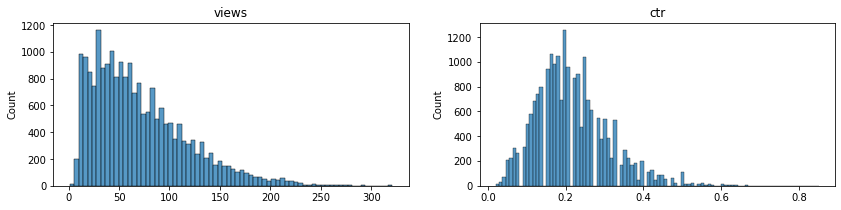

In [18]:
# Получим массив NumPy размером n_users с помощью генератора rng 
# choice - метод для генерации случайных выборок из заданного массива
sim_views = rng.choice(views_distribution['views'], size=n_users, replace=True, p=views_distribution['p'])
sim_ctrs = rng.choice(ctr_distribution['ctr'], size=n_users, replace=True, p=ctr_distribution['p'])
# Посмотрим на распределение сэмплированных просмотров и CTR
# Сделаем фигуру из двух графиков 
fig, ax = plt.subplots(1, 2, figsize=(14,3))
sns.histplot(sim_views, ax=ax[0])
ax[0].set_title('views')
sns.histplot(sim_ctrs, ax=ax[1])
ax[1].set_title('ctr')

<Axes: ylabel='Count'>

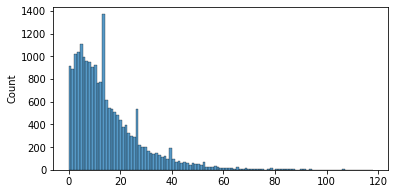

In [19]:
# Поскольку лайки это случайная величина, зависящая от просмотров, мы допускаем что просмотр 
# это как испытаение а вероятность успеха испытания это CTR
# Сэмплируем лайки из биномиального распределения просмотров с вероятностью p=sim_ctrs
plt.figure(figsize=(6, 3))
sim_clicks = rng.binomial(n=sim_views.astype("int64"), p=sim_ctrs)
sns.histplot(sim_clicks)

In [ ]:
Проведем АА тест на наших выбоках и посмотрим что они однородны по лайкам.
Напишем функцию которая посчитает количество ложных срабатываний т-теста

In [23]:
""" sample_size: размер выборок
    views_df: датафрейм со значениями просмотров и их вероятностями
    ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    nsim: количество симуляций (по умолчанию 1000)
    return: значение мощности от 0 до 1 """
def fpr_calc(sample_size, views_df, ctr_df, nsim=1000):

    pvalues = [] #список, куда мы будем складывать p-value
    #симуляируем и сравниваем выборки nsim раз:
    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

    #возвращаем долю - как все значения (Folse+True) в массиве/на число True которые <0.05
    return np.mean(np.array(pvalues) < 0.05)

In [24]:
fpr_calc(sample_size=n_users, views_df=views_distribution, ctr_df=ctr_distribution, nsim=1000)

100%|██████████| 1000/1000 [00:11<00:00, 85.05it/s]


0.047

In [ ]:
Ожидаемый результат - наши выборки статистически однородны

In [ ]:
''' Наш алгоритм добавляет 1-2 (1 или 2 будем делать как 50%) просмотра с 90% вероятностью
    т.е. у нас 0 или 1 -это условно сколько лайков будем добавлять к 1 постоянному лайку
    а далее условия на 90% - это тоже массив 0 и 1, и на >50 просмотров - это массив True/False
    У кого менее 50 просмотров не сработает'''
(1 + rng.binomial(n=1, p=0.5, size=n)) * rng.binomial(n=1, p=0.9, size=n) * (group_B_views >= 50)

In [29]:
def power_calc(sample_size, views_df, ctr_df, threshold, nsim=1000):
    p = []
    for _ in tqdm(range(nsim)):
        #симулируем просмотры
        group_A_views = rng.choice(views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        #симулируем эффект в тестовой группе
        group_B_views = group_B_views + \
        ((1 + rng.binomial(n=1, p=0.5, size=sample_size)) * rng.binomial(n=1, p=0.9, size=sample_size)\
         * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")
        #симулируем CTR
        group_A_ctr = rng.choice(ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        #симулируем лайки
        likes_A = rng.binomial(group_A_views, group_A_ctr)
        likes_B = rng.binomial(group_B_views, group_B_ctr)
        #сравниваем t-тестом и сохраняем p-value
        p.append(stats.ttest_ind(likes_A, likes_B, equal_var=False).pvalue)
    
    return np.mean(np.array(p) < 0.05)

In [30]:
# Для пользователей с числом просмотров > 50
power_calc(sample_size=n_users, views_df=views_distribution, ctr_df=ctr_distribution, nsim=1000, threshold=50)

100%|██████████| 1000/1000 [00:12<00:00, 80.49it/s]


0.261

In [ ]:
'''Мощность теста при условии что наши изменения в 1-2 просмотра должны изменить количество лайков при
текущих условия не достаточная чтоб это заметить'''

In [31]:
# Для пользователей с числом просмотров > 30 и увеличим число экспериментов
power_calc(sample_size=n_users, views_df=views_distribution, ctr_df=ctr_distribution, nsim=20000, threshold=30)

100%|██████████| 20000/20000 [04:08<00:00, 80.36it/s]


0.42825

In [ ]:
'''Мощность увеличилась но еще до 80% далеко
   Попробуем увеличить период с 1 до 2 недель - это увеличит размер наших выборок
   Найдем этот размер через запрос в кликхаус'''

In [32]:
# 2 недели
q = """
SELECT uniqExact(user_id)    
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2024-12-27') and toDate(time) <= toDate('2025-01-08')
     """
n_users = ph.read_clickhouse(q, connection=connection)
n_users = int(n_users.iloc[0,0]//2)
# Сколько попадёт в одну группу при равной разбивке
n_users

29903

In [33]:
# Для пользователей с числом просмотров > 30 и увеличенным размером выборки (2недели)
power_calc(sample_size=n_users, views_df=views_distribution, ctr_df=ctr_distribution, nsim=20000, threshold=30)

100%|██████████| 20000/20000 [05:49<00:00, 57.15it/s]


0.56225

In [ ]:
''' 56%  для двух недель - маловато. Что можно попробовать еще?
    Возьмем пользователей в тест, только таких, у которых больше 30 просмотров
    Для этого немного изменим функцию, добавим фильтр в виде маски'''

In [36]:
def power_calc_mask(sample_size, views_df, ctr_df, threshold, nsim=1000):
    p = []
    for _ in tqdm(range(nsim)):
        #симулируем просмотры
        group_A_views = rng.choice(views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        #симулируем эффект в тестовой группе
        group_B_views = group_B_views + \
        ((1 + rng.binomial(n=1, p=0.5, size=sample_size)) * rng.binomial(n=1, p=0.9, size=sample_size)\
         * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")
        #симулируем CTR
        group_A_ctr = rng.choice(ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        # маски для фильтрации по просмотрам - это масиив True/Fals
        mask_A = group_A_views >= 30 # Маска создается на основе просмотров, но применяется к кликам,
        mask_B = group_B_views >= 30 # чтобы отобрать клики только тех пользователей, 
                                     # которые удовлетворяют условию (≥30 просмотров). 
        
        #симулируем лайки
        likes_A = rng.binomial(group_A_views, group_A_ctr)
        likes_B = rng.binomial(group_B_views, group_B_ctr)
        #сравниваем t-тестом и сохраняем p-value
        p.append(stats.ttest_ind(likes_A[mask_A], likes_B[mask_B], equal_var=False).pvalue)
    
    return np.mean(np.array(p) < 0.05)

In [37]:
# Только для пользователей с числом просмотров > 30 и увеличенным размером выборки (2недели)
power_calc_mask(sample_size=n_users, views_df=views_distribution, ctr_df=ctr_distribution, nsim=20000, threshold=30)

100%|██████████| 20000/20000 [05:54<00:00, 56.49it/s]


0.65085

In [ ]:
'''65% если фильтровать пользователей, увеличить выборку, и если алгоритм 
   будет работать пользователями > 30 просмотров.
   В таких условиях детектировать изменения в лайках (при условии изменения в просмотрах на +1-2)с заданным 
   уровнем мощности 80% не получится
   Но можно, если есть такая возможность увеличивать выборку (время теста)
   Можно добабатывать алгорит чтоб он работал на более широкую аудиторию или
   давал более значительные результаты чем +2 просмотра''' 